# Week 3: Attention MIL Pooling

We will be working through the basic implementation of Attention MIL Pooling as described in the following paper (without gated attention): https://arxiv.org/pdf/1802.04712.pdf

Function to load bags have been provided for convenience. Your task will be to take each bag and feed it through the Attention class below to learn how to aggregate scores efficiently.

Examples of bags and their corresponding labels are provided below.

In [1]:
import numpy as np

# Load the dataset (MNIST to begin and then move to P-CAM)
def build_mnist_bags(train_images, train_labels, image_id = 9, bag_size=10):
  random_ids = np.arange(len(train_labels))
  np.random.shuffle(random_ids)

  # make sure there are enough instances per bag and randomize
  number_bags = int(len(train_labels) / bag_size)
  train_images = train_images[random_ids[:number_bags * bag_size], ...]
  train_labels = train_labels[random_ids[:number_bags * bag_size], ...]

  # split dataset into bags
  train_images = train_images.reshape(number_bags, bag_size, train_images.shape[1], train_images.shape[2], train_images.shape[2])
  train_labels = train_labels.reshape(number_bags, bag_size)

  # find bag-level label
  bag_labels = []
  for i in train_labels:
    if image_id in i:
      bag_labels.append(1)
    else:
      bag_labels.append(0)

  return train_images, bag_labels

In [2]:
# Code to display a positive and negative bag
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Original paper only uses training set
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))

train_dataset_images = next(iter(train_loader))[0].numpy()
train_dataset_labels = next(iter(train_loader))[1].numpy()

bags_images, bags_labels = build_mnist_bags(train_dataset_images, train_dataset_labels)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


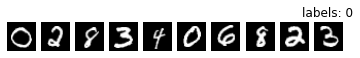

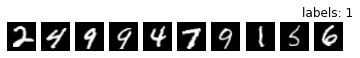

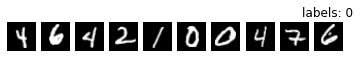

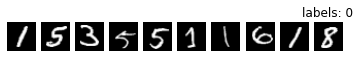

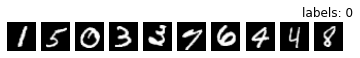

In [3]:
# Display first 5 example bags
for j in range(5):
  plt.figure()
  for idx, bag_instance in enumerate(bags_images[j]):
    plt.subplot(j+1, bags_images.shape[1], idx + 1)
    plt.imshow(np.squeeze(bag_instance.transpose(1,2,0)), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
  plt.title("labels: " + str(bags_labels[j]))
  plt.show()

## Task 1: Build an Attention class

Create a class derived from nn.Module which 
* Creates a basic model architecture similar to AlexNet and create a L length embedding for each batch. The output will be of length N*L where N is the number of instances in a batch, and L is the embedding length which you may choose
* Create a 2-layer multi-layer perceptron to learn attention weights
* Wrap the two network above in a forward(...) function and combine attention weights and embeddings into one score for the entire batch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MILAttention(nn.Module):
  def __init__(self, num_instances = 10, length_final_layer=256, att_l1_length = 128):
    super(MILAttention, self).__init__()
    
    self.num_instances = num_instances
    self.L = length_final_layer
    self.l1_length = att_l1_length
    self.gated = True
    
    # Add the following functions below which create each component of the model
    # described in the practical session
    # Suggestion: wrap each model around nn.Sequential
    # see https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html for an example 
    self.base_model = self.build_alexnet()
    self.attention_mlp = self.build_attention_mlp()
    self.classifier = self.build_alexnet_end()

    # for gating option, we define these layers:
    self.gated_l11 = nn.Linear(self.L, self.l1_length)
    self.gated_l12 = nn.Linear(self.L, self.l1_length)
    self.gated_glu = nn.GLU()
    self.gated_l2 = nn.Linear(self.l1_length, 1)
    
  def build_alexnet_end(self):
    # Build the final layer of the MIL architecture here
    # Output will be of size 1
    return nn.Sequential(nn.Linear(self.L, 1), nn.Sigmoid())

  def build_alexnet(self):
    # Build a basic model here 
    # We will be using AlexNet-like architecture as a starting point
    # You may choose to make this model as complex/simple as you like
    return nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=5),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(64 * 4 * 4, 256),
      nn.ReLU(),
      nn.Linear(256, self.L),  
      nn.ReLU()
    )

  def build_attention_mlp(self):
    # 2-layer MLP architecture
    # Optionally, add gated attention 
   return nn.Sequential(
      nn.Linear(self.L, self.l1_length),
      nn.Tanh(),
      nn.Linear(self.l1_length, 1))

  def attention_gated_mlp(self, x):
    x1 = self.gated_l11(x)
    x2 = self.gated_l12(x)
    x = torch.cat((x1,x2), 1)
    x = self.gated_glu(x)
    x = self.gated_l2(x)
    return x
      
  def forward(self, x):
    # 1 - Your forward function must call self.base_model and self.attention_mlp
    H = self.base_model(x)

    if self.gated:
      A = self.attention_gated_mlp(H)
    else:
      A = self.attention_mlp(H)

    # 2 - Apply a softmax to self.attention_mlp output and transpose
    A = torch.transpose(A, 1, 0)
    A = F.softmax(A, dim=1)
    #print(H.shape, A.shape)

    # 3 - Multiple attention with embedded representation (i.e. output from self.base_model)
    # Equation 7
    A_H = torch.mm(A, H)
    
    # 4 - Pass into self.classifier to generate a single value for all instances
    out = self.classifier(A_H)

    return out
    

## Task 2: Feed bags into your model

Here you need to feed the bags created above through the network. Remember that you only have **one** label for every 10 instances (by default). Your loss will be computed from this one label.

In [5]:
def train_epoch(model, epochs, images, labels, loss_function, optimizer, device):
  train_loss = 0
  for batch_idx in range(len(labels)):
    # get one bag and label associated with it
    batch_img, batch_lbl = images[batch_idx], labels[batch_idx]
    batch_img = torch.tensor(batch_img, device=device).float()
    batch_lbl = torch.tensor(batch_lbl, device=device).long()

    optimizer.zero_grad()

    out = model(batch_img)
    # PyTorch does not allow different input and output sizes 
    # So we build our own here
    out = torch.clamp(out, min=1e-5, max=1. - 1e-5)   # need this to eliminate nans
    loss = -1. * (batch_lbl * torch.log(out) + (1. - batch_lbl) * torch.log(1. - out))
    #loss = loss_function(out, batch_lbl)

    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx, len(labels),
            100. * batch_idx / len(labels), loss.item()))
        
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(labels)))
  return


def test_model(model, images, labels):
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx in range(len(labels)):
      # get one bag and label associated with it
      batch_img, batch_lbl = images[batch_idx], labels[batch_idx]
      batch_img = torch.tensor(batch_img, device=device).float()
      batch_lbl = torch.tensor(batch_lbl, device=device).int()
      
      out = model(batch_img)
      total += 1
      #print(batch_lbl, torch.ge(out, 0.5).int())
      correct += (batch_lbl == torch.ge(out, 0.5).int()).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
  return

In [6]:
batch_size = 10
num_epochs = 20
device='cuda'

mil_model = MILAttention(num_instances = batch_size)
mil_model.to(device)
mil_model.train()

optimizer = torch.optim.Adam(mil_model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):
    train_epoch(mil_model, epoch, bags_images, bags_labels, loss_function, optimizer, device)


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.706213
Train Epoch: 1 [100/6000 (2%)]	Loss: 0.805536
Train Epoch: 1 [200/6000 (3%)]	Loss: 0.993144
Train Epoch: 1 [300/6000 (5%)]	Loss: 0.900871
Train Epoch: 1 [400/6000 (7%)]	Loss: 0.418061
Train Epoch: 1 [500/6000 (8%)]	Loss: 0.203473
Train Epoch: 1 [600/6000 (10%)]	Loss: 1.110325
Train Epoch: 1 [700/6000 (12%)]	Loss: 1.043488
Train Epoch: 1 [800/6000 (13%)]	Loss: 0.521311
Train Epoch: 1 [900/6000 (15%)]	Loss: 1.119470
Train Epoch: 1 [1000/6000 (17%)]	Loss: 0.532754
Train Epoch: 1 [1100/6000 (18%)]	Loss: 0.497618
Train Epoch: 1 [1200/6000 (20%)]	Loss: 0.438894
Train Epoch: 1 [1300/6000 (22%)]	Loss: 0.390145
Train Epoch: 1 [1400/6000 (23%)]	Loss: 0.449225
Train Epoch: 1 [1500/6000 (25%)]	Loss: 0.973562
Train Epoch: 1 [1600/6000 (27%)]	Loss: 0.497004
Train Epoch: 1 [1700/6000 (28%)]	Loss: 0.445868
Train Epoch: 1 [1800/6000 (30%)]	Loss: 0.475303
Train Epoch: 1 [1900/6000 (32%)]	Loss: 1.304348
Train Epoch: 1 [2000/6000 (33%)]	Loss: 1.297130
Train Epoc

In [7]:
# Load the test set
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

test_dataset_images = next(iter(test_loader))[0].numpy()
test_dataset_labels = next(iter(test_loader))[1].numpy()

bags_images, bags_labels = build_mnist_bags(test_dataset_images, test_dataset_labels)

# Test model performance
mil_model.eval()
test_model(mil_model, bags_images, bags_labels)

Accuracy of the network on the 10000 test images: 65 %
